# Predicting Bike Rentals

In past years, people have used shared bicycles which you can rent from bike sharing stations. I have a data set which has information about bike rentals. This data is collected by Hadi Fanaee-T at the University of Porto. 
<br>
<br>
In this project, I will use this data set to predict bike rentals. I will start with exploring this data set.

## Exploratory Analysis

In [1]:
import pandas as pd

bike_rentals= pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [2]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


I have 17379 non-null entries for each column. To summarize, the columns have information about the various conditions in which bikes were rented such as: time, weather, etc. I will predict the "cnt" column. The "cnt" column shows the amount of rentals. This column is created from the sum of the "casual" and "registered" columns. So, I won't use the "casual" and "registered" columns while creating my prediction model. Let's create a histogram to see distribution for the "cnt" column. 

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

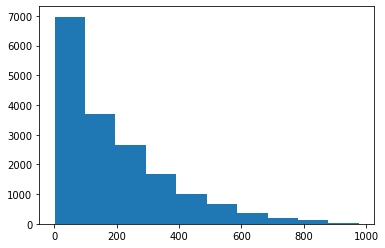

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(bike_rentals["cnt"])

In [4]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [5]:
bike_rentals["hr"].value_counts()

16    730
17    730
15    729
13    729
14    729
22    728
18    728
19    728
20    728
21    728
23    728
12    728
7     727
8     727
9     727
10    727
11    727
0     726
6     725
1     724
5     717
2     715
4     697
3     697
Name: hr, dtype: int64

You can see the correlations of columns with the "cnt" column above. Also, I counted the "hr" column which gives the hour information. I want to categorize this column to make predictions easy for my machine learning model. If I use 24 hours separately, the model will use them as different values. However, the hours can relate to each other like morning, afternoon or evening. I want to collect related hours, so I will create a function to return hours categorized. It will split the hours as 1(morning), 2(afternoon), 3(evening), 4(night). 

In [6]:
def assign_label(hour):
    if hour>=0 and hour<6:
        return 4
    elif hour>=6 and hour<12:
        return 1
    elif hour>= 12 and hour<18:
        return 2
    elif hour>= 18 and hour<=24:
        return 3
    
bike_rentals["time_label"]= bike_rentals["hr"].apply(assign_label)

In [7]:
bike_rentals["time_label"].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

## Prediction Step

I have finished my exploratory analysis and feature engineering on the "bike_rentals" dataframe. My data is ready for a prediction to be made. Before creating a prediction model, I will split the data to "train" and "test".  

In [8]:
train= bike_rentals.sample(frac=.8)

In [9]:
test= bike_rentals.loc[~bike_rentals.index.isin(train.index)]

I split the data. First, I will use linear regression model to make a prediction. I will calculate the model's success with mean squared error metric. My data is a continuous numeric set and MSE works on it.  

In [10]:
from sklearn.linear_model import LinearRegression

predictors= list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")


reg= LinearRegression()

reg.fit(train[predictors], train["cnt"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
import numpy

predictions= reg.predict(test[predictors])

print("The MSE value for the linear regression model: ")
numpy.mean((predictions - test["cnt"])**2)


The MSE value for the linear regression model: 


17613.475847152

The error is too high with the linear regression model. I will apply the decision tree algorithm.

In [12]:
from sklearn.tree import DecisionTreeRegressor

reg= DecisionTreeRegressor(min_samples_leaf=5)

reg.fit(train[predictors], train["cnt"])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [13]:
predictions= reg.predict(test[predictors])
print("The MSE value for the decision tree model: ")
numpy.mean((predictions - test["cnt"])**2)

The MSE value for the decision tree model: 


2512.7855767690676

The MSE value is substantially reduced with decision tree model. I will set the "min_samples_leaf" parameter as 2 and check the result.

In [14]:
reg= DecisionTreeRegressor(min_samples_leaf=2)

reg.fit(train[predictors], train["cnt"])

predictions= reg.predict(test[predictors])

print("The MSE value for the decision tree model: ")

numpy.mean((predictions - test["cnt"])**2)

The MSE value for the decision tree model: 


2746.537758918294

The MSE value did not reduce. I will try random forests.

In [15]:
from sklearn.ensemble import RandomForestRegressor

reg= RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train["cnt"])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
predictions= reg.predict(test[predictors])
print("The MSE value for the random forest model: ")
numpy.mean((predictions- test["cnt"])**2)

The MSE value for the random forest model: 


1864.4636808284379

The MSE value looks better now.

## Conclusion
<br>
<br>
After exploratory analysis, I set different machine learning models for predictions on the bike_rentals data set. As an error metric, I calculated the mean squared errors. With linear regression model, the MSE value is very high. This value reduced better with decision trees. In the last step, I tried random forest on my prediction. I obtained the best MSE value with random forest algorithm.   